# 🤒 Epidemic mitigation project - environment tutorial

This notebook is a tutorial on how to interact with the *epidemic simulation environment* provided for the miniproject.

## Installing the environment

1. Install conda
2. Create a dedicated environment
3. Install from requirements.txt
4. Run a test

In [1]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env
from epidemic_env.dynamics import ModelDynamics 
from epidemic_env.visualize import Visualize
%matplotlib inline

### Loading the environment object and running it
In the following cell we instanciate a dynamical model (of the `ModelDynamics` class) that implements the epidemic simulation. The simulation parameters are set by the config file that we load (here `switzerland.yaml`). We then demonstrate how one can query the list of cities from the dynamical model and how one can plot the map on which the simulation will happen. 

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


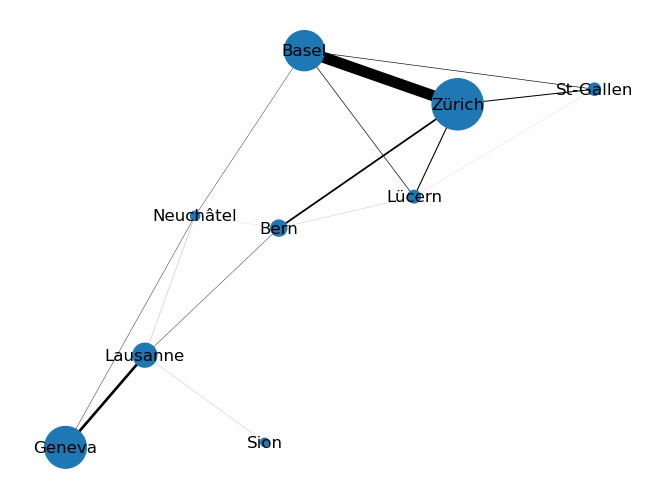

In [5]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
print(dyn.cities)
dyn.draw_map()

### Instanciating the environment object
The environment provides a wrapper for an agent to interact with, it implements a step method that allows an agent to make observations and picking actions that will impact the environment. We show how to reset the environment (which is also the procedure used for initialization and for *seeding* the random number generators).

In [8]:
"""Loading the environment"""
env = Env(  dyn,
            action_space=None,
            observation_space=None,
            )

""" Resetting the environment """
obs, info = env.reset(seed=0) # We pass a seed to the env to ensure reproductibility


In [8]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

"""Loading the environment"""
env = Env(  dyn,
            action_space=None,
            observation_space=None,
            )

action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

""" Run the simulation """
finished = False
obs, info = env.reset()
print(f"Content of the obs dict : {obs.keys()}")
print(f"obs['total'] : {obs['total']}") # contains the infected and death counts for each day of the week (for the entire country)
print(f"obs['city']['Lausanne'] : {obs['total']}") # contains same information as obs['total'] per in a per-city basis
print(f"obs['pop'] : {obs['pop']}") # contains the population (deaths are note removed) of each city (this is useful for normalization)


fig, ax = plt.subplots(3,2) # TODO : define a cuter plotting routine
ax[0,0].scatter(range(7),obs['city']['infected']['Lausanne'])
ax[0,0].set_title('Lausanne infections')
ax[0,1].scatter(range(7),obs['city']['dead']['Lausanne'])
ax[0,1].set_title('Lausanne deaths')
ax[1,0].scatter(range(7),obs['city']['infected']['Geneva'])
ax[1,0].set_title('Geneva infections')
ax[1,1].scatter(range(7),obs['city']['dead']['Geneva'])
ax[1,1].set_title('Geneva deaths')
ax[2,0].scatter(range(7),obs['city']['infected']['Bern'])
ax[2,0].set_title('Bern infections')
ax[2,1].scatter(range(7),obs['city']['dead']['Bern'])
ax[2,1].set_title('Bern deaths')
fig.tight_layout()
plt.show()

AttributeError: 'Observation' object has no attribute 'keys'

In [3]:
env.render()

Epidemic state : 
   - dead: 178
   - infected: 15075


In [8]:
import torch

torch.manual_seed(0)
torch.use_deterministic_algorithms(True)


### The observation dict

At each time step the environment returns an observation in the form of a dictionnary stuctured as follows. This is the dictionnary of informations that can be used by the environment.
```python
obs = {
    'total': { # country-wide measurements (for each day of the week)
        'infected': [0, 79, 204,... # infected people
        'dead': [0, 0, 1, ... # dead people
    },
    'city': { # per-city measurements (for each day of the week)
        'infected': {
            'Lausanne': [0, 79, 198, ... # infected people
            'Geneva': [0, 0, 0, .. # dead people
        },
        'dead': {
            'Lausanne': [0, 0, 1, ... # infected people
            'Geneva': [0, 0, 0, .. # dead people
        },
    },
    'pop': { # population (deaths are note removed)
        'Lausanne': 295000
        'Geneva': 900000 ... # For all cities
    },
}
```

### The action dict
Actions are controlled by the following dictionnary:
```python
action = {
        'confinement': True, # when true, all cities are confined
        'isolation': False, # when true, all cities are isolated from each other
        'hospital': True, # when true, extra hospital beds are added (lowers mortality)
        'vaccinate': False, # when true, vaccination is performed (immunity rises)
    }
```


### The information dict
At each time step the environment returns an information log in the form of a dictionnary stuctured as follows. This is **not observable by the agent** but rather useful for logging the agent's behavior
```python
information = {
        'parameters':{ # internal model parameters
            'total':{ # for the entire country
                'day':0 
                'suceptible':3733950, 
                ... # all internal model paraeters
            },
            'cities':{ # for a given city
                'Lausanne':{
                    'day':0, # all internal model paraeters at the end of a week
                    'suceptible':294975, 
                    ...
                },
                'Geneva':... # all internal model paraeters
                ...
            },
        },
        'action':{ # action last taken
            'confinement':True, 
            'isolation':False, 
            'vaccinate':True, 
            'hospital':False
        }
    }
```